In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from scipy import stats as sps
from matplotlib import pyplot as plt

%matplotlib inline

### Generate data

In [2]:
def gen_first(alpha, w, X, noise_sigma=0):
    """alpha, w, size - tuples with 2 elements
    x = alpha[0] * sin(w[0] * x) + alpha[1] * cos(w[1] * x) + N(0, noise_sigma^2), 
    X - list with x_train, x_val, x_test..."""
    Y = []
    for x in X:
        x = np.array(x)
        y = alpha[0] * np.sin(w[0] * x) + alpha[1] * np.cos(w[1] * x)
        y += np.random.randn(x.shape[0]) * noise_sigma
        Y.append(y)
    return Y

In [3]:
X = sps.uniform(loc=0, scale=1).rvs(size=1000)
X_train, X_test = train_test_split(X, test_size=0.2)
X_train, X_val = train_test_split(X_train, test_size=0.3)

In [4]:
y_train, y_val, y_test = gen_first([1, 2], [2, 3], [X_train, X_val, X_test], noise_sigma=0.01)

In [5]:
print('alpha true = [1, 2]')
print('w true = [2, 3]')

alpha true = [1, 2]
w true = [2, 3]


### Model

In [6]:
def true_func(alpha, w, x):
    return alpha[0] * np.sin(w[0] * x) + alpha[1] * np.cos(w[1] * x)

In [7]:
class ModelFirst(torch.nn.Module):
    def __init__(self):
        super(ModelFirst, self).__init__()
        self.alpha = torch.tensor([2., 2.], dtype=torch.float64, requires_grad=True)
        self.w = torch.tensor([-2., 2.], dtype=torch.float64, requires_grad=True)
        
    def forward(self, x):
        return self.alpha[0] * torch.sin(self.w[0] * x) + self.alpha[1] * torch.cos(self.w[1] * x)

In [8]:
def compute_loss(model, x, y):
    """x, y - numpy arrays"""
    x = torch.DoubleTensor(x)
    y = torch.DoubleTensor(y)
    y_pred = model(x)
    return F.mse_loss(y_pred, y)# + 0.001 * (model.alpha ** 2).sum() + 0.001 * (model.w ** 2).sum()

## Darts

In [9]:
def find_opt(model, xi=0.1, num_epochs=100):
    train_loss, val_loss, test_loss, params = [], [], [], []
    
    opt_w = torch.optim.SGD([model.w], lr=xi)
    opt_alpha = torch.optim.SGD([model.alpha], lr=0.1)

    for epoch in range(num_epochs):
        model.train(True) # устанавливаем поведение dropout / batch_norm  в обучение

        loss = compute_loss(model, X_train, y_train) # first level
        loss.backward()
        w_grad = model.w.grad.clone().detach()
        opt_w.step()
        opt_w.zero_grad()
        opt_alpha.zero_grad()
        train_loss.append(loss.data.numpy())
                
        model.w.requires_grad_(False)
        #model.w -= w_grad * xi # virtual step
                
        loss = compute_loss(model, X_val, y_val) # second level
        loss.backward()
        opt_alpha.step()
        opt_alpha.zero_grad()
        opt_w.zero_grad()
        val_loss.append(loss.data.numpy())
        
        #model.w += w_grad * xi
        model.w = model.w.requires_grad_(True)
        params.append((model.alpha.clone().detach().numpy(), model.w.clone().detach().numpy()))
                
        loss = compute_loss(model, X_test, y_test)
        test_loss.append(loss.data.numpy())
    return train_loss, val_loss, test_loss, np.array(params)

In [12]:
def fun(X, Y):
    return [((x * np.sin(y * X_train) + 2 * np.cos(3 * X_train) - y_train) ** 2).mean() for x, y in zip(X, Y)]

x = np.arange(-2, 2.5, 0.1)
y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(x, y)
zs = np.array(fun(np.ravel(X), np.ravel(Y)))
Z = zs.reshape(X.shape)

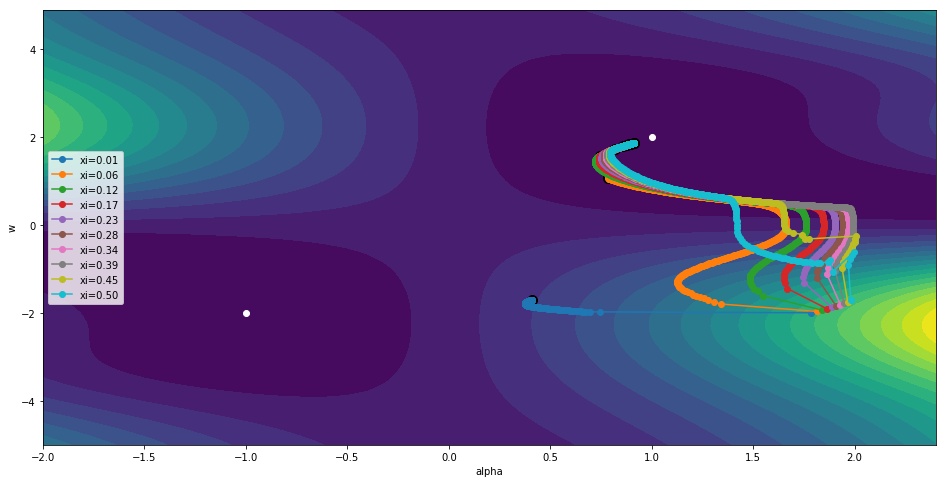

In [13]:
plt.figure(figsize=(16, 8))
best_loss = 100
plt.contourf(X, Y, Z, levels=20)
for xi in np.linspace(0.01, 0.5, num=10):
    model = ModelFirst()
    train_loss, val_loss, test_loss, params = find_opt(model, xi=xi, num_epochs=10001)
    plt.plot(params[::20, 0, 0], params[::20, 1, 0], '-o', label=f'xi={xi:.2f}')
    plt.scatter(params[-1, 0, 0], params[-1, 1, 0], color='black', s=100)
    if train_loss[-1] < best_loss:
        best_loss = train_loss[-1]
        best_xi = xi
        model_best = model
plt.xlabel('alpha')
plt.ylabel('w')
plt.scatter([1, -1], [2, -2], color='white')
plt.legend(loc=6)
plt.savefig('surface_4.png')
plt.show()

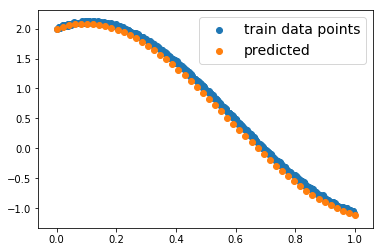

In [14]:
plt.scatter(X_train, y_train, label='train data points')
plt.scatter(np.linspace(0, 1), [true_func([model_best.alpha.clone().detach().numpy()[0], 2], 
                                           [model_best.w.clone().detach().numpy()[0], 3], x)
                                 for x in np.linspace(0, 1)], label='predicted')
plt.legend(prop={'size': 14})
plt.show()

Выводы:
* Градиентный спуск не всесилен и возникают большие проблемы с застряванием в локальных минимумах, а не в глобальным при использовании функций активации с большим кол-вом экстремумов (например, sin, cos при условии что x принимает значения на большом промежутке > pi)

In [15]:
model_best.w

tensor([1.8771, 2.8993], dtype=torch.float64, requires_grad=True)

In [16]:
model_best.alpha

tensor([0.9131, 2.0276], dtype=torch.float64, requires_grad=True)

In [17]:
best_loss, best_xi

(array(0.0001962), 0.5)